In [139]:
import pandas as pd
import numpy as np
import rioxarray
import rasterio

import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [140]:
uganda_data = pd.read_csv("Uganda Malaria Data/mock_malaria_cases_uganda_2km_2018.csv")

In [141]:
Z = uganda_data["malaria"].to_numpy().reshape(-1, 1)

In [142]:
x = uganda_data["x"].to_numpy()

In [143]:
y = uganda_data["y"].to_numpy()

In [144]:
lst = uganda_data["lst"].to_numpy()

In [145]:
rain = uganda_data["rainfall"].to_numpy()

In [146]:
elevation = uganda_data["elevation"].to_numpy()

In [147]:
X = np.stack((x, y, lst, rain, elevation), axis = -1)

In [148]:
X

array([[ 3.14833333e+01, -9.75000000e-01,  1.36289000e-01,
        -3.55831770e-01, -8.99079440e-02],
       [ 3.12166667e+01,  1.07500000e+00, -1.00910865e-01,
        -4.25240730e-01, -1.22246650e-01],
       [ 3.49666667e+01, -7.91666667e-01, -3.92890840e-01,
         1.47240940e+00,  2.50894830e+00],
       ...,
       [ 3.19166667e+01,  2.60833333e+00,  7.36701800e-01,
         4.97378830e-01, -6.83764200e-01],
       [ 3.15333333e+01, -5.75000000e-01, -3.44774400e-01,
        -6.04611340e-01,  1.05594255e-01],
       [ 3.16666667e+01,  3.90833333e+00,  1.08179750e+00,
         1.36470630e-02, -5.30155360e-01]])

In [149]:
rbf = gpflow.kernels.RBF(active_dims = [0, 1], lengthscales=.1)
linear = gpflow.kernels.Linear(active_dims = [2, 3, 4])
kernel = rbf + linear

In [150]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)

In [151]:
model = gpflow.models.GPR(data = (X_train, Y_train), kernel = kernel)

In [152]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -14.141525703590453
        x: [ 6.457e+03  6.902e+03 -3.001e+00 -5.256e+00 -5.641e+00]
      nit: 48
      jac: [ 1.150e-11 -7.036e-10  3.904e-07  2.967e-07  3.198e-06]
     nfev: 68
     njev: 68
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [153]:
malaria_prevalence = rioxarray.open_rasterio("Uganda Malaria Data/mock_malaria_prevelance_uganda_2km_2018.tif").squeeze()

In [154]:
left, bottom, right, top = malaria_prevalence.rio.bounds()

In [155]:
x = np.linspace(left, right, 285)
y = np.linspace(bottom, top, 285)
x1, x2 = np.meshgrid(x, y)
X_grid = np.stack((x1.ravel(), x2.ravel()), axis = -1)

In [156]:
with rasterio.open("Uganda Standardized Rasters/standard_uganda_LSTday_2km_2018.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
lst_data = np.array(values)

In [157]:
with rasterio.open("Uganda Standardized Rasters/standard_uganda_Rainfall_CHIRPS_2km_2018.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
rain_data = np.array(values)

In [158]:
with rasterio.open("Uganda Standardized Rasters/standard_uganda_elevation_2km.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
elevation_data = np.array(values)

In [159]:
X_grid = np.concatenate((X_grid, lst_data[:, np.newaxis], rain_data[:, np.newaxis], elevation_data[:, np.newaxis]), axis = -1)

In [160]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [161]:
# Make predictions on the grid
Z_fmean_grid, Z_fvar_grid = model.predict_f(X_grid)

# Reshape the grid predictions to match the grid shape
Z_fmean_grid = Z_fmean_grid.reshape(x1.shape)
Z_fvar_grid = Z_fvar_grid.reshape(x1.shape)

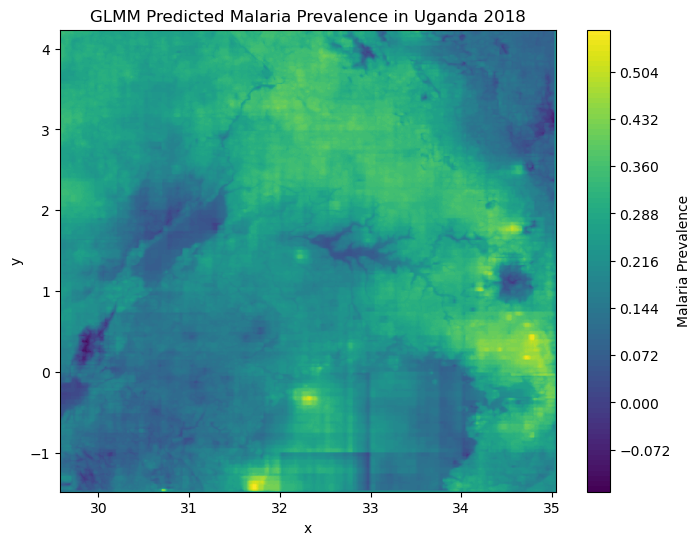

In [162]:
plt.figure(figsize=(8, 6))
plt.contourf(x, y, Z_fmean_grid, levels=100, cmap='viridis')
plt.colorbar(label='Malaria Prevalence')

plt.xlabel('x')
plt.ylabel('y')
plt.title('GLMM Predicted Malaria Prevalence in Uganda 2018')
plt.savefig("Uganda Malaria Data/lengthscaletenth_mock_malaria_cases_uganda_randomfield_2km_2018.png") 
plt.show()